In [281]:
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import ast
import collections
from Bio import pairwise2
sys.path.append('../../Codes/lib/')
from functions_memory import*

/Users/robertomorantovar/anaconda3/envs/flai/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
from collections import defaultdict
import pandas as pd
import numpy as np
import argparse
import flai
import os
import glob
import sqlite3
from tqdm import tqdm
from flai.util.vir.flu.DriverSites import DriverSites
from flai.util.Utils import Utils
from flai.util.Time import Time
import sys
from flai.tree.LeanTree import LeanTree
from flai.tree.LeanCladeTree import LeanCladeTree
    
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
args, unknown = parser.parse_known_args()

In [3]:
%%time
args.tree_db = '/Users/robertomorantovar/Library/CloudStorage/Dropbox/Temp_Tree_Share/H3N2/2024_07_02/tree.db'
args.output = '/Users/robertomorantovar/Library/CloudStorage/Dropbox/My_Documents/Science/Projects/Immune_System/_Repository/Codes/analysis/memory_response/sera/out'
args.lineage = 'H3N2'
DriverSites.setH3N2()

args.c = ['CRICK', 'CDC', 'VIDRL']
args.a = ['FRAVNT', 'HINT', 'HI']
args.sm = ['CELL']

con = sqlite3.connect(args.tree_db, timeout=1000)
cur = con.cursor()
df_tree = pd.read_sql_query("SELECT nid, pid, rcluster, clade, db_sequence, mutations, name, collection_date, multiplicity, epi, region, leaf_count FROM Tree",con)
df_clades = pd.read_sql_query("SELECT * FROM SignificantClades WHERE frequency_threshold = 0.05",con)
df_antigenic = pd.read_sql_query('SELECT strainNode, rstrainNode,'
                                 'alphaClade, rhoClade, epi_dist, titre,'
                                 'centre, assay,serumMedium, train '
                                 'FROM AntigenicData', con)
df_Ear = pd.read_sql_query("SELECT rho, alpha, Ealpharho_ALL_ALL_CELL FROM Ealpharho",con)
con.close()
    
clade2sclade = {a[0]:a[1] for a in zip(list(df_clades.clade),list(df_clades.antigenic_clade))}
clade2label = {a:b for a,b in zip(df_clades.clade, df_clades.clade_label)}
df_tree['antigenic_clade'] = [clade2sclade[a] for a in df_tree.clade]
df_tree['FLAI_time'] = [Time.dateToCoordinate(a) for a in df_tree.collection_date]
# df_tree = df_tree.loc[df_tree["FLAI_time"]>Time.dateToCoordinate("2005-01-01")]

tt = LeanTree()
tt.initialize(df_tree)
tt.set_significant_clades(clade2sclade)
tt.compute_node_frequencies(inclusive_frequencies=True)

clade_tree = LeanCladeTree(tt, significantAlphas=True)
clade_tree.compute_clade_frequencies()

# set train-test beforehand
df_antigenic = df_antigenic.loc[[c in args.c for c in df_antigenic.centre]]
df_antigenic = df_antigenic.loc[[a in args.a for a in df_antigenic.assay]]
df_antigenic = df_antigenic.loc[[sm in args.sm
                                 for sm in df_antigenic.serumMedium]]
df_antigenic['alphaClade'] = [tt.nodes[nid].cladeSalpha for nid in df_antigenic.strainNode]
df_antigenic['rhoClade'] = [tt.nodes[nid].cladeSalpha for nid in df_antigenic.rstrainNode]
df_antigenic['mesmul'] = np.ones(len(df_antigenic))

epiA = [122, 124, 126, 131, 133, 135, 137, 142, 143, 144, 145, 146]
epiB = [155, 156, 157, 158, 159, 160, 163, 164, 186, 188, 189, 190, 192, 193, 196, 197]
epiC = [50, 53, 54, 275, 276, 278, 299, 307]
epiD = [121, 172, 173, 174, 201, 207, 213, 217, 226, 227, 242, 244, 248]
epiE = [57, 62, 63, 67, 75, 78, 81, 82, 83, 92, 94, 260, 262]
epis = np.array(epiA + epiB + epiC + epiD + epiE)
epis2 = [np.array(epiA), np.array(epiB), np.array(epiC), np.array(epiD), np.array(epiE)]

# a = defaultdict(lambda: 0.0)



6.59	LeanTree: initializing tree from db

182.57	LeanTree: Computing frequency normalization of nodes

219.32	LeanTree: Computing exclusive frequencies

254.61	LeanTree: Computing inclusive frequencies

346.89	LeanCladeTree: Computing exclusive clade frequencies

370.88	LeanCladeTree: Computing inclusive clade frequencies
CPU times: user 5min 59s, sys: 7.74 s, total: 6min 7s
Wall time: 6min 11s


In [ ]:
df_antigenic = df_antigenic.loc[df_antigenic['epi_dist']<25]
df_antigenic['titre2'] = np.log2(df_antigenic['titre'])
df_antigenic['titre2_norm'] = df_antigenic['titre2'] - np.mean(df_antigenic.loc[df_antigenic['epi_dist']==0]["titre2"])

epi_distrib = []
for index, row in df_antigenic.iterrows():
    node1 = tt.nodes[row['strainNode']]
    node2 = tt.nodes[row['rstrainNode']]
    seq1 = np.array([aa for aa in ast.literal_eval(df_sequence.loc[df_sequence['hashed_sequence']==node1.db_sequence].iloc[0]['gene_aa_sequence'])['HA1']])
    seq2 = np.array([aa for aa in ast.literal_eval(df_sequence.loc[df_sequence['hashed_sequence']==node2.db_sequence].iloc[0]['gene_aa_sequence'])['HA1']])
    epi_muts = []
    for epi in epis2:
        seq1_epi = seq1[epi-1]
        seq2_epi = seq2[epi-1]
        epi_muts.append(len(epi)-len(epi[seq1_epi==seq2_epi]))
    epi_distrib.append(epi_muts)
df_antigenic['epi_distrib'] = epi_distrib

In [ ]:
immuno_vector = []
for index, row in df_antigenic.iterrows():
    df_trial = df_antigenic.loc[df_antigenic['rstrainNode']==row['rstrainNode']]
    M = np.zeros(5)
    for index, row in df_trial.iterrows():
        M = np.vstack((M, row['epi_distrib']))
    M = M[1:,:]
    x = np.linalg.lstsq(M, np.array(df_trial['titre2_norm']), rcond=None)[0]
    immuno_vector.append(list(x*-1))
df_antigenic['immuno_vector'] = immuno_vector

In [244]:
treedb = sqlite3.connect(args.tree_db, isolation_level = None)
df_sequence = pd.read_sql_query("SELECT hashed_sequence, gene_aa_sequence FROM Sequence",treedb)

In [4]:
df_tree

,nid,pid,rcluster,clade,db_sequence,mutations,name,collection_date,multiplicity,epi,region,leaf_count,antigenic_clade,FLAI_time
0,1,141,EPI_ISL_69272,1,-6123693368193680711,"{""nl"": {""nl"": [""C1650T""], ""HA"": [""C1650T""], ""H...",A/HONGKONG/15MA213/1968,1968-01-01,1,EPI_ISL_69272,South East Asia,0,1,24837
1,2,143,EPI_ISL_69272,2,7854752214787496984,"{""nl"": {""nl"": [""A850G"", ""C1994T""], ""HA"": [""A85...",A/HONGKONG/15MA212/1968,1968-01-01,1,EPI_ISL_20831,South East Asia,0,1,24837
2,3,143,EPI_ISL_69272,2,6114078943756665637,"{""nl"": {""nl"": [""C54T"", ""G2290A"", ""A2992G""], ""H...",A/HONGKONG/16MA212/1968,1968-01-01,1,EPI_ISL_22823,South East Asia,0,1,24837
3,4,144,EPI_ISL_69272,3,-2205059221957087966,"{""nl"": {""nl"": [""A677G"", ""G2893A""], ""HA"": [""A67...",A/HONGKONG/12MA212/1968,1968-01-01,1,EPI_ISL_20828,South East Asia,0,1,24837
4,5,147,EPI_ISL_69272,4,-6884075074187205694,"{""nl"": {""nl"": [""C533T"", ""G1507A""], ""HA"": [""C53...",A/HONGKONG/11MA12B/1968,1968-01-01,1,EPI_ISL_25010,South East Asia,0,1,24837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211621,211622,14859,EPI_ISL_120417,4043,-8560213868742694335,"{""nl"": {""nl"": [""A1541G""], ""HA"": [""A1541G""], ""H...",A/GEORGIA/18/2014,2014-11-29,31,EPI_ISL_250926,North America,1,2630,41971
211622,211623,105485,EPI_ISL_120417,24464,156220847904780517,,A/MICHIGAN/MISL374581574/2024,2024-02-23,12,EPI_ISL_19064681,North America,1,18608,45344
211623,211624,78856,EPI_ISL_120417,19429,-8555748178310128990,"{""nl"": {""nl"": [""A63G""], ""HA"": [""A63G""], ""HA1"":...",A/ILLINOIS/15/2022,2022-04-14,6,EPI_ISL_12713980,North America,1,13341,44664
211624,211625,37991,EPI_ISL_120417,10972,2595375476704754200,"{""nl"": {""nl"": [""C244T"", ""G473A"", ""G886A"", ""A15...",A/QUEBEC/115/2018,2018-02-06,23,EPI_ISL_395652,North America,1,8711,43136


In [101]:
df_clades

,level_0,index,clade,frequency_threshold,significant_clade,clade_label,antigenic_clade,p_antigenic_clade,defining_node,who_significant_clade,voi_clade,epi_inference_clade
0,0,0,1,0.05,1,Root,1,1,141,1,1,1
1,1,1,2,0.05,1,Root,1,1,141,1,1,1
2,2,2,3,0.05,1,"Root, HA:E234G",1,1,141,1,1,1
3,3,3,4,0.05,1,"Root, HA:E234G, NA:P468H",1,1,141,1,1,1
4,4,4,5,0.05,1,"Root, HA:E234G, HA:G140D,N181D",1,1,141,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
25104,25104,25104,25105,0.05,24945,"2a.1b.2a.2a.3a.1,122D,276E, NA:M24L, HA:K223R,...",18608,17351,74459,18608,18608,3880
25105,25105,25105,25106,0.05,24945,"2a.1b.2a.2a.3a.1,122D,276E, NA:M24L, HA:K223R,...",18608,17351,74459,18608,18608,3880
25106,25106,25106,25107,0.05,24945,"2a.1b.2a.2a.3a.1,122D,276E, NA:M24L, HA:K223R,...",18608,17351,74459,18608,18608,3880
25107,25107,25107,25108,0.05,24945,"2a.1b.2a.2a.3a.1,122D,276E, NA:M24L, HA:K223R,...",18608,17351,74459,18608,18608,3880


In [364]:
df_antigenic

,strainNode,rstrainNode,alphaClade,rhoClade,epi_dist,titre,centre,assay,serumMedium,train,mesmul,titre2,titre2_norm,epi_distrib,immuno_vector
0,152065,152065,12930,12930,0,2112.423539,CDC,HI,CELL,1.0,1.0,11.044683,0.327220,"[0, 0, 0, 0, 0]","[0.10178193562725069, 0.8866994338116385, -0.2..."
2,152065,59166,12930,13340,2,1436.029360,CDC,HI,CELL,8.0,1.0,10.487870,-0.229594,"[0, 1, 1, 0, 0]","[0.43978167368234455, 0.9514949510678504, -0.3..."
4,59166,152065,13340,12930,2,1218.889545,CDC,HI,CELL,4.0,1.0,10.251352,-0.466112,"[0, 1, 1, 0, 0]","[0.10178193562725069, 0.8866994338116385, -0.2..."
6,59166,59166,13340,13340,0,2048.000000,CDC,HI,CELL,5.0,1.0,11.000000,0.282537,"[0, 0, 0, 0, 0]","[0.43978167368234455, 0.9514949510678504, -0.3..."
12,210675,152065,12468,12930,3,128.000000,CDC,HI,CELL,7.0,1.0,7.000000,-3.717463,"[0, 1, 2, 0, 0]","[0.10178193562725069, 0.8866994338116385, -0.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210478,159644,158268,19946,15066,8,256.000000,CRICK,HI,CELL,1.0,1.0,8.000000,-2.717463,"[3, 2, 2, 0, 1]","[0.0755454332924568, 0.4229410351655497, 0.182..."
210479,159644,45856,19946,12641,6,512.000000,CRICK,HI,CELL,3.0,1.0,9.000000,-1.717463,"[2, 1, 3, 0, 0]","[0.12094234342464336, 0.5017414125976457, 0.35..."
210481,159644,190904,19946,15859,7,512.000000,CRICK,HI,CELL,2.0,1.0,9.000000,-1.717463,"[2, 1, 4, 0, 0]","[0.23820499735185025, 0.5265691360594512, 0.31..."
210482,159644,189805,19946,17351,2,512.000000,CRICK,HI,CELL,0.0,1.0,9.000000,-1.717463,"[1, 0, 1, 0, 0]","[0.012849018679198318, 1.3143589774767965, 0.4..."


In [245]:
df_sequence

,hashed_sequence,gene_aa_sequence
0,-6123693368193680711,{'HA': 'MKTIIALSYIFCLALGQDLPGNDNSTATLCLGHHAVPN...
1,7854752214787496984,{'HA': 'MKTIIALSYIFCLALGQDLPGNDNSTATLCLGHHAVPN...
2,6114078943756665637,{'HA': 'MKTIIALSYIFCLALGQDLPGNDNSTATLCLGHHAVPN...
3,-2205059221957087966,{'HA': 'MKTIIALSYIFCLALGQDLPGNDNSTATLCLGHHAVPN...
4,-6884075074187205694,{'HA': 'MKTIIALSYIFCLALGQDLPGNDNSTATLCLGHHAVPN...
...,...,...
194256,-3694147814054151097,{'HA': 'MKAIIALSNILCLVFAQKIPGNDNSTATLCLGHHAVPN...
194257,-8560213868742694335,{'HA': 'MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPN...
194258,-8555748178310128990,{'HA': 'MKTIIALSNILCLVFAQKIPGNDNSTATLCLGHHAVPN...
194259,2595375476704754200,{'HA': 'MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPN...


In [ ]:
fig, ax = plt.subplots(figsize=(5*1.62, 5), gridspec_kw={'left':0.12, 'right':.9, 'bottom':.1, 'top': 0.96})
sns.lineplot(data = df_antigenic, x = "epi_dist", y =df_antigenic["titre2_norm"], ax = ax, lw = 3, color = my_blue)
# sns.scatterplot(data = df_antigenic, x = "new_epi_dist", y = np.log2(df_antigenic["titre2_norm"]), ax = ax, color = 'lightblue', marker = '.')
titre_drop = df_antigenic.loc[df_antigenic['epi_dist']<20].groupby('epi_dist')['titre2_norm'].mean()
popt, pcov = curve_fit(my_linear_func, ydata = titre_drop.values, xdata = titre_drop.index)
print(popt)
ax.plot(titre_drop.index, popt[0] + popt[1]* titre_drop.index, color = my_blue2)
my_plot_layout(ax = ax, xscale='linear', yscale= 'linear', ticks_labelsize= 24, x_fontsize=30, y_fontsize=30)
# ax.set_xlim(right = 16)
ax.set_ylim(top = 0.1)
fig.savefig("../../Figures/memory_response/data/Titre_d.pdf");
# plt.close()

In [139]:
fig, ax = plt.subplots(figsize=(5*1.62, 5), gridspec_kw={'left':0.12, 'right':.9, 'bottom':.1, 'top': 0.96})
for d in range(0, 11, 5):
    homologous_titres = np.log2(df_antigenic.loc[df_antigenic['new_epi_dist']==d]['titre'])
    titre_array = np.linspace(-3, 18, 20)
    hist_data = ax.hist(homologous_titres, bins = titre_array, histtype='step', label = str(d), density = True)#, cumulative = True, density = False)
my_plot_layout(ax = ax, xscale='linear', yscale= 'linear', ticks_labelsize= 24, x_fontsize=30, y_fontsize=30)
ax.legend(fontsize = 20, title = 'Epi_dist')
fig.savefig("../../Figures/memory_response/data/Distribution_Titre_d.pdf");
plt.close()

In [138]:
fig, ax = plt.subplots(figsize=(5*1.62, 5), gridspec_kw={'left':0.12, 'right':.9, 'bottom':.1, 'top': 0.96})
titre_array = np.linspace(-3, 18, 20)
sns.histplot(data = df_antigenic.loc[df_antigenic['new_epi_dist']<20], x = 'titre2', bins = titre_array, hue = "new_epi_dist", common_norm = True, multiple="stack")#, cumulative = True, density = False)
my_plot_layout(ax = ax, xscale='linear', yscale= 'linear', ticks_labelsize= 24, x_fontsize=30, y_fontsize=30)
# ax.legend(fontsize = 20, title = 'Epi_dist')
ax.set_yscale('log')
fig.savefig("../../Figures/memory_response/data/Distribution_Titre_d.pdf");
plt.close()

In [386]:
fig, ax = plt.subplots(figsize=(5*1.62, 5), gridspec_kw={'left':0.12, 'right':.9, 'bottom':.1, 'top': 0.96})
clade_nodes = clade_tree.nodes
days = np.linspace(24702, 45545, 45545 - 24702 + 1)
inter_freq_stacked = np.zeros_like(days)
for i in clade_nodes.keys():
    inter_freqs = np.zeros_like(days)
    incl_freq = clade_nodes[i].frequency_exclusive
    ordered_incl_freq = collections.OrderedDict(sorted(incl_freq.items()))
    for day in days:
        if day in incl_freq.keys():
            inter_freqs[int(day)-24702] = incl_freq[day]
    inter_freq_stacked = np.vstack([inter_freq_stacked, inter_freqs])
ax.stackplot(days, inter_freq_stacked[1:, :], alpha = .9)
my_plot_layout(ax = ax, xscale='linear', yscale= 'linear', ticks_labelsize= 24, x_fontsize=30, y_fontsize=30)
ax.set_xlim(left = 33000, right = 45545)
ax.set_ylim(top = 1)
fig.savefig("../../Figures/memory_response/data/clade_freqs_excl.pdf")
plt.close()

In [86]:
fig, ax = plt.subplots(figsize=(5*1.62, 5), gridspec_kw={'left':0.12, 'right':.9, 'bottom':.1, 'top': 0.96})
clade_nodes = clade_tree.alpha2node
inter_freq_stacked = np.zeros_like(days)
for i in clade_nodes.keys():
    incl_freq = clade_nodes[i].frequency_inclusive
    ordered_incl_freq = collections.OrderedDict(sorted(incl_freq.items()))
    ax.plot(ordered_incl_freq.keys(), ordered_incl_freq.values())
my_plot_layout(ax = ax, xscale='linear', yscale= 'linear', ticks_labelsize= 24, x_fontsize=30, y_fontsize=30)
ax.set_xlim(left = 33000, right = 45545)
# ax.set_yscale('log')
ax.set_ylim(bottom = .1, top = 1.01)
fig.savefig("../../Figures/memory_response/data/clade_freqs_incl.pdf");
plt.close()


In [87]:
fig, ax = plt.subplots(figsize=(5*1.62, 5), gridspec_kw={'left':0.12, 'right':.9, 'bottom':.1, 'top': 0.96})
clade_nodes = clade_tree.alpha2node
days = np.linspace(24702, 45545, 45545 - 24702 + 1)
inter_freq_stacked = np.zeros_like(days)
for i in clade_nodes.keys():
    inter_freqs = np.zeros_like(days)
    incl_freq = clade_nodes[i].frequency_inclusive
    for day in days:
        if day in incl_freq.keys():
            inter_freqs[int(day)-24702] = incl_freq[day]
    inter_freq_stacked = np.vstack([inter_freq_stacked, inter_freqs])
ax.stackplot(days, inter_freq_stacked[1:, :], alpha = .6)
ax.plot(days, np.sum(inter_freq_stacked, axis = 0), color = 'k')
ax.plot(days, np.exp(2.3e-4*(days-33000)), color = 'darkred', ls = '--')
my_plot_layout(ax = ax, xscale='linear', yscale= 'linear', ticks_labelsize= 24, x_fontsize=30, y_fontsize=30)
ax.set_xlim(left = 33000, right = 45545)
ax.set_yscale('log')
ax.set_ylim(bottom = .8)
fig.savefig("../../Figures/memory_response/data/clade_freqs_incl_cum.pdf")
plt.close()

In [14]:
2.3e-4*365*10

0.8394999999999999

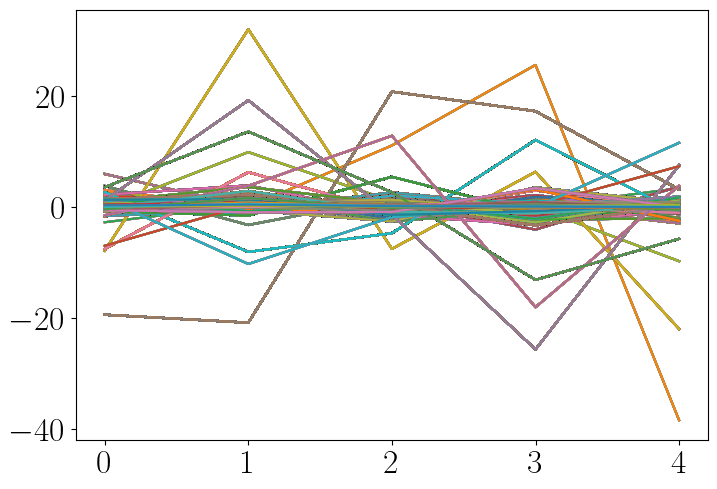

In [414]:
kappa_clades = np.unique(df_antigenic['rhoClade'])
fig, ax = plt.subplots(figsize=(5*1.62, 5), gridspec_kw={'left':0.12, 'right':.9, 'bottom':.1, 'top': 0.96})
sum_immuno_vectors = np.zeros(5)
counter = 0
for rhoid in kappa_clades:
    for index, row in df_antigenic.loc[df_antigenic['alphaClade']==rhoid].iterrows():
        immuno_vector = np.array(row['immuno_vector'])
        immuno_vector/=np.sum(immuno_vector)
        # sum_immuno_vectors += np.array(row['immuno_vector'])
        # counter+=1
        ax.plot(range(5), immuno_vector, label = str(row['rstrainNode']), alpha = .8)
my_plot_layout(ax = ax, xscale='linear', yscale= 'linear', ticks_labelsize= 24, x_fontsize=30, y_fontsize=30)
# ax.set_xlim(left = 33000, right = 45545)
# ax.set_ylim(top = 1)
fig.savefig("../../Figures/memory_response/data/immuno_vectors_total.pdf")


In [17]:
tt.nodes[clade_tree.alpha2node[clade_tree.alphas[1]].id].time, Time.coordinateToDate(tt.nodes[clade_tree.alpha2node[clade_tree.alphas[1]].id].time)

(33603, datetime.date(1992, 1, 1))

In [ ]:
ast.literal_eval(df_tree.iloc[444]['mutations'])

In [195]:
tt.nodes[44419].cladeSalpha, clade_tree.alpha2node[12930].id

(12930, 44419)

In [358]:
a = np.array([[1, 2], [3, 5], [3, 5]])
b = np.array([1, 2, 6])
y = np.linalg.lstsq(a, b, rcond=None)[0]
y


array([ 3., -1.])